<a href="https://colab.research.google.com/github/chidera20/Chidera_Adv_ML_Project/blob/main/Final_Project_AdvMachinceLearning_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Embedding

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load the data from the file
file_path = 'breach_report_archive.txt'
data = pd.read_csv(file_path, delimiter='\t', encoding='latin1')

In [ ]:
# Convert 'Breach Submission Date' to datetime
data['Breach Submission Date'] = pd.to_datetime(data['Breach Submission Date'])

In [ ]:
# Encode categorical variables
label_encoders = {}
for column in ['State', 'Covered Entity Type', 'Type of Breach', 'Location of Breached Information', 'Business Associate Present']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [ ]:
# Define categorical features and target variable
categorical_features = ['State', 'Covered Entity Type', 'Type of Breach', 'Location of Breached Information', 'Business Associate Present']
textual_feature = 'Web Description'
target = 'Individuals Affected'

In [ ]:
# Binarize the target variable for classification
data['High Risk'] = data[target] > data[target].median()
y = data['High Risk'].astype(int)

In [ ]:
# Tokenize and pad sequences for RNN and CNN models
max_words = 5000  # Maximum number of words to consider in the vocabulary
max_len = 512     # Maximum length of sequences

In [ ]:
# Ensure the textual_feature column contains only strings
data[textual_feature] = data[textual_feature].astype(str)

In [ ]:
tokenizer_keras = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer_keras.fit_on_texts(data[textual_feature])
sequences = tokenizer_keras.texts_to_sequences(data[textual_feature])
X_textual_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split the padded sequences into training and testing sets
X_train_textual, X_test_textual, y_train_textual, y_test_textual = train_test_split(X_textual_padded, y, test_size=0.2, random_state=42)

## RNN Model (LSTM)

In [ ]:
from tensorflow.keras.layers import Dropout # Import Dropout

In [ ]:
# Define RNN model (LSTM) with increased complexity and regularization
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
rnn_model.add(LSTM(128, return_sequences=True))
rnn_model.add(LSTM(64))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train RNN model (LSTM) with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_model.fit(X_train_textual, y_train_textual, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5365 - loss: 0.6882 - val_accuracy: 0.5895 - val_loss: 0.6729
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6310 - loss: 0.6506 - val_accuracy: 0.6970 - val_loss: 0.5947
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7805 - loss: 0.4866 - val_accuracy: 0.7387 - val_loss: 0.5430
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.6587 - loss: 0.6060 - val_accuracy: 0.5609 - val_loss: 0.6858
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6585 - loss: 0.6108 - val_accuracy: 0.7530 - val_loss: 0.5349
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8179 - loss: 0.4194 - val_accuracy: 0.7596 - val_loss: 0.5320
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.7595 - loss: 0.4787 - val_accuracy: 0.6158 - val_loss: 0.6121
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7015 - loss: 0.5539 - val_accu

In [ ]:
# Evaluate RNN model (LSTM)
y_pred_rnn_proba = rnn_model.predict(X_test_textual).flatten()
y_pred_rnn = (y_pred_rnn_proba > 0.5).astype(int)
accuracy_rnn = accuracy_score(y_test_textual, y_pred_rnn)
report_rnn = classification_report(y_test_textual, y_pred_rnn)

36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step


## CNN Model

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling1D  # Import GlobalMaxPooling1D

In [ ]:
# Define CNN model with increased complexity and regularization
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train CNN model with early stopping
cnn_model.fit(X_train_textual, y_train_textual, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 38s 311ms/step - accuracy: 0.5494 - loss: 0.6810 - val_accuracy: 0.8277 - val_loss: 0.4044
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 255ms/step - accuracy: 0.8314 - loss: 0.3461 - val_accuracy: 0.8869 - val_loss: 0.2647
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 252ms/step - accuracy: 0.8969 - loss: 0.2179 - val_accuracy: 0.8858 - val_loss: 0.2695
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.9163 - loss: 0.1792 - val_accuracy: 0.8683 - val_loss: 0.3156
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.9261 - loss: 0.1398 - val_accuracy: 0.8705 - val_loss: 0.3186


In [ ]:
# Evaluate CNN model
y_pred_cnn_proba = cnn_model.predict(X_test_textual).flatten()
y_pred_cnn = (y_pred_cnn_proba > 0.5).astype(int)
accuracy_cnn = accuracy_score(y_test_textual, y_pred_cnn)
report_cnn = classification_report(y_test_textual, y_pred_cnn)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


## Evaluate and Compare Models
Plot ROC Curves and Confusion Matrices

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Import the necessary libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

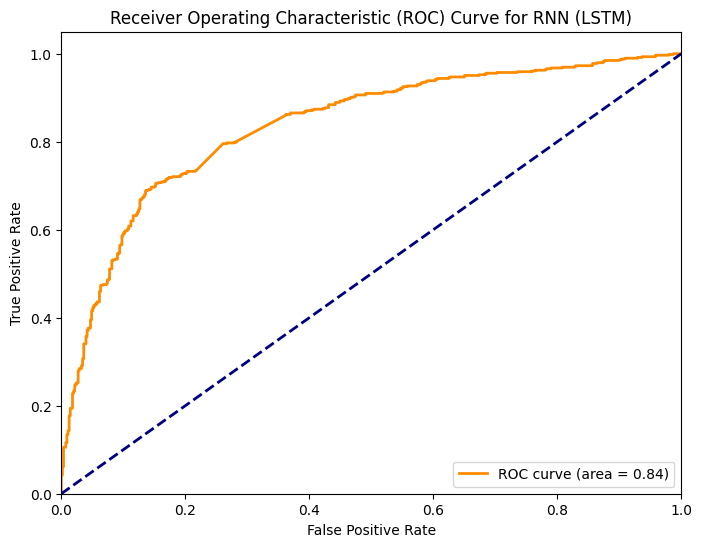

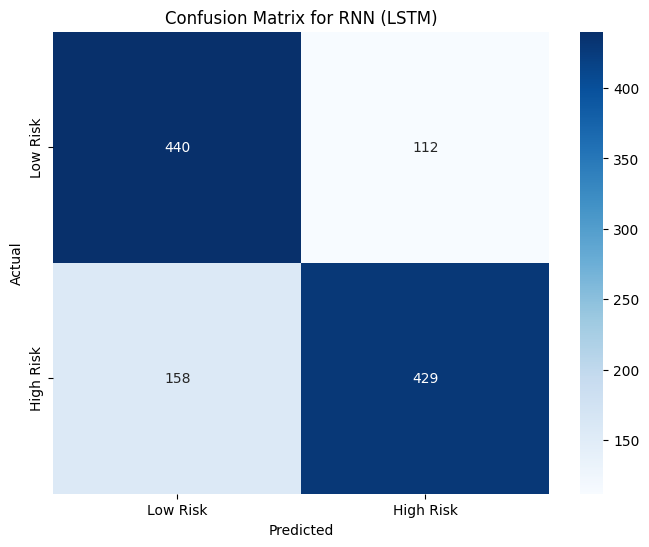

In [ ]:
# Plot ROC curve and confusion matrix for RNN
plot_roc_curve(y_test_textual, y_pred_rnn_proba, 'RNN (LSTM)')
plot_confusion_matrix(y_test_textual, y_pred_rnn, 'RNN (LSTM)')

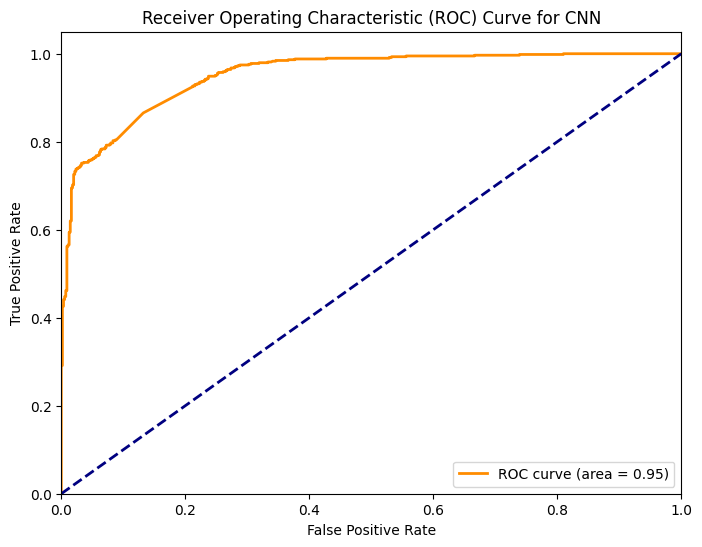

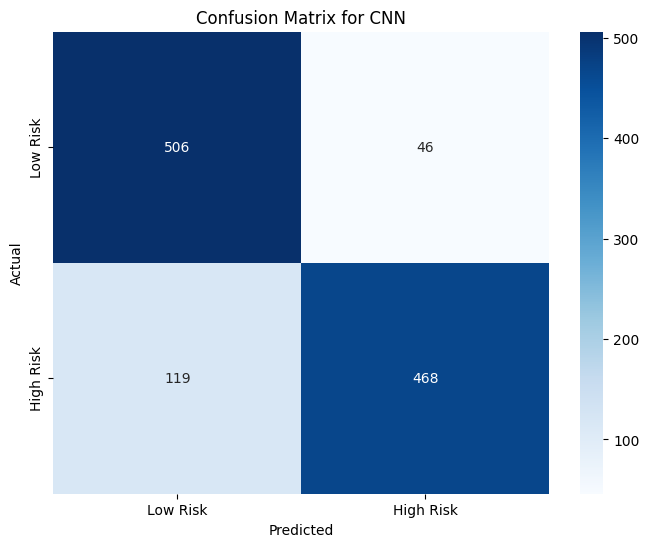

In [ ]:
# Plot ROC curve and confusion matrix for CNN
plot_roc_curve(y_test_textual, y_pred_cnn_proba, 'CNN')
plot_confusion_matrix(y_test_textual, y_pred_cnn, 'CNN')

In [ ]:
# Print results for RNN
print(f"Model: RNN (LSTM)")
print(f"Accuracy: {accuracy_rnn}")
print(f"Classification Report:\n{report_rnn}\n")

Model: RNN (LSTM)
Accuracy: 0.7629499561018437
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       552
           1       0.79      0.73      0.76       587

    accuracy                           0.76      1139
   macro avg       0.76      0.76      0.76      1139
weighted avg       0.77      0.76      0.76      1139




In [ ]:
# Print results for CNN
print(f"Model: CNN")
print(f"Accuracy: {accuracy_cnn}")
print(f"Classification Report:\n{report_cnn}\n")

Model: CNN
Accuracy: 0.8551360842844601
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       552
           1       0.91      0.80      0.85       587

    accuracy                           0.86      1139
   macro avg       0.86      0.86      0.85      1139
weighted avg       0.86      0.86      0.85      1139




In [ ]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Function to encode texts in batches
def encode_texts_in_batches(texts, batch_size=32):
    encoded_batches = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encoded_inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=512)
        with torch.no_grad():
            outputs = model(**encoded_inputs)
        encoded_batches.append(outputs.last_hidden_state.mean(dim=1).numpy())
    return np.vstack(encoded_batches)